In [1]:
# Import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
from datetime import datetime
import warnings
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'KS-L5VYs__ekXkiyhgwP'

## Step 2. Import data set

In [3]:
# Importing the OECD "Greece, Terms of Trade" variable.

data = quandl.get('OECD/NAAG_GRC_TOT')

In [4]:
data.head(5)

,Value
Date,
1970-12-31,92.545327
1971-12-31,87.616060
1972-12-31,85.098713
1973-12-31,90.247608
1974-12-31,88.535556


In [5]:
data.shape

(52, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

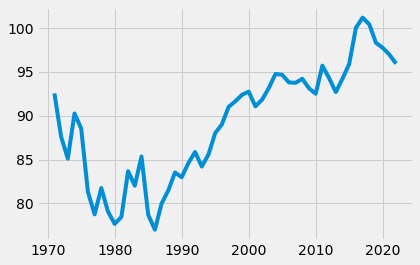

In [9]:
plt.plot(data)

## Step 3. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1970-12-31,92.545327
1,1971-12-31,87.616060
2,1972-12-31,85.098713
3,1973-12-31,90.247608
4,1974-12-31,88.535556


In [12]:
# Keeping the data from the past 25 years only. The Greek economy has experienced a lot of changes, positive and
# negative, the past 20 years. Therefore data older than 30 years are not very relevant to this analysis.

data_sub = data_2.loc[(data_2['Date'] >= '1997-01-01') & (data_2['Date'] < '2022-12-20')]

In [13]:
data_sub.shape

(25, 2)

In [14]:
data_sub.head()

,Date,Value
27,1997-12-31,91.635935
28,1998-12-31,92.376092
29,1999-12-31,92.740368
30,2000-12-31,91.064773
31,2001-12-31,91.818983


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
1997-12-31,91.635935
1998-12-31,92.376092
1999-12-31,92.740368
2000-12-31,91.064773
2001-12-31,91.818983


## Step 4. Create a line chart of your data.

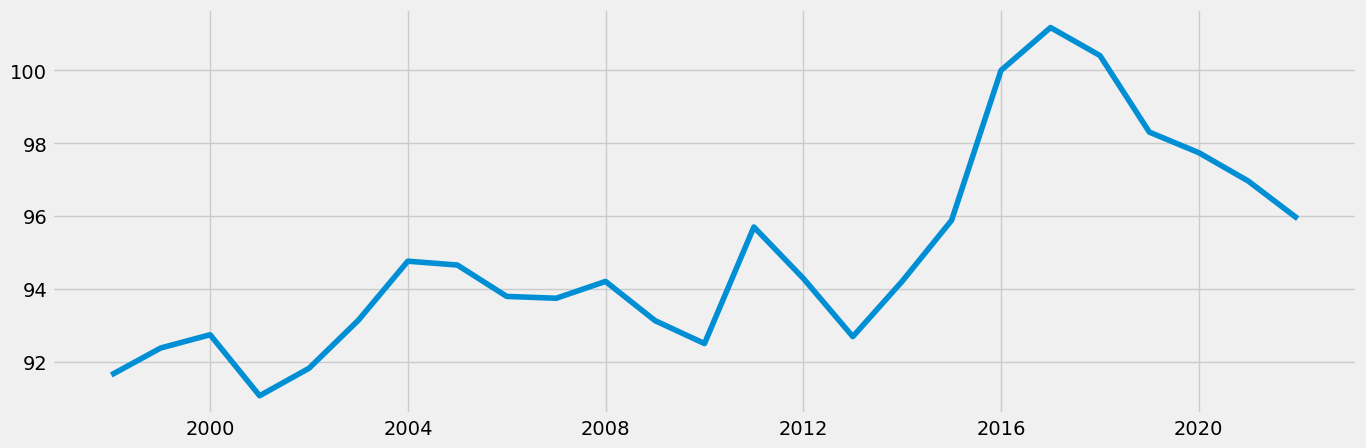

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates. None found.

dups = data_sub.duplicated()
dups.sum()

0

## Decompose the data’s components.

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

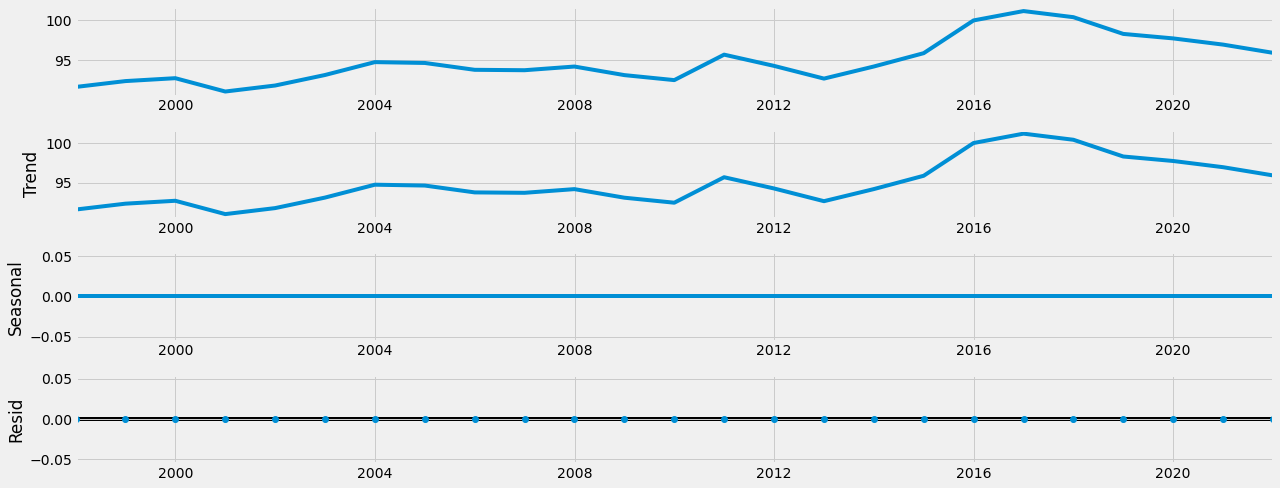

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

### The trend in the chart above gradually rises. There are a few drops, after 2008, 2010 and 2018. These can be attributed to the financial crisis which brought financial and political instability for 10 years, as well as Covid. The overall trend continues to rise when compared to 1997. This appears to be the dominant trend.

### We do not have any seasonality because the curve is flat.

### There is no unexplained noise as there are no up-and-down deviations on the 'residual' chart.

## Step 6. Conduct a Dickey-Fuller test to check for stationarity.

In [22]:
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [23]:
# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.860903
p-value                         0.350671
Number of Lags Used             1.000000
Number of Observations Used    23.000000
Critical Value (1%)            -3.752928
Critical Value (5%)            -2.998500
Critical Value (10%)           -2.638967
dtype: float64


### lW ewill use a significance level of 5 percent. The “Critical Value (5%)” in the results has a value of -2.998500. This is much smaller than the test statistic, which is -1.860903, which means that we cannot reject the null hypothesis.

### This showed that there is a unit root in our data, and the data is non-stationary. 

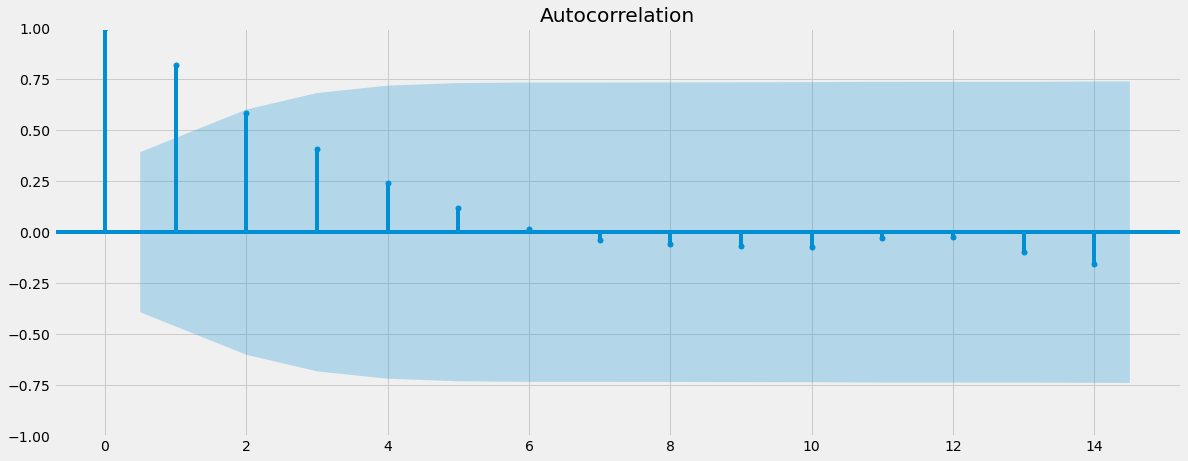

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## Step 7. Conduct a round of differencing on the data and repeat step 6.

In [25]:
data_diff = data_sub - data_sub.shift(1)

In [26]:
data_diff.dropna(inplace = True)

In [27]:
data_diff.head()

,Value
datetime,
1998-12-31,0.740157
1999-12-31,0.364276
2000-12-31,-1.675595
2001-12-31,0.754210
2002-12-31,1.321643


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

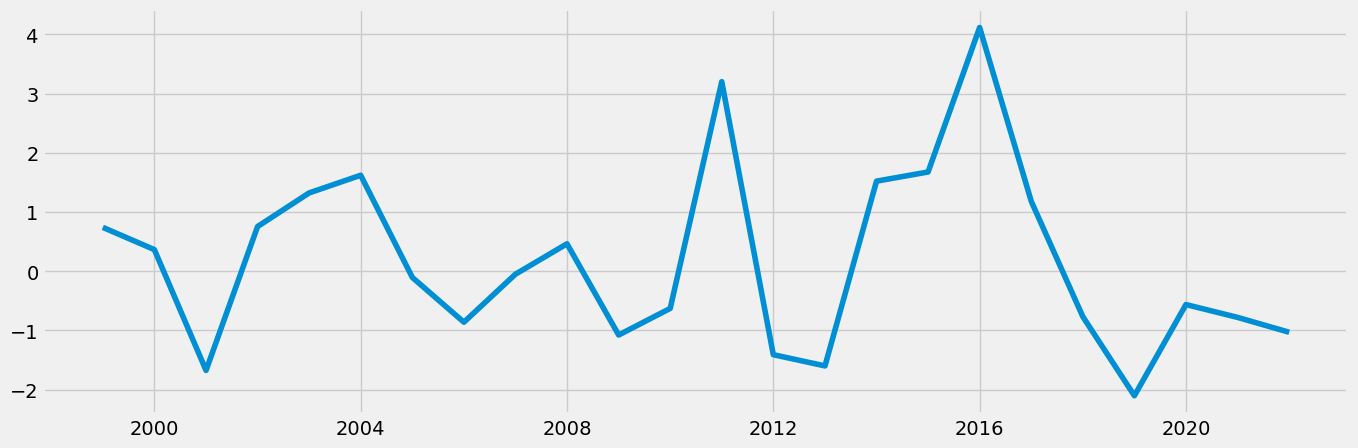

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -2.809185
p-value                         0.056974
Number of Lags Used             9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


### The test statistic is now smaller than the critical value at the ten percent significance level. The p-value is close to being <0.05. We will conduct another round of differencing.

In [31]:
data_diff_2 = data_diff - data_diff.shift(1)

In [32]:
data_diff_2.dropna(inplace = True)

In [33]:
data_diff_2.head()

,Value
datetime,
1999-12-31,-0.375881
2000-12-31,-2.039871
2001-12-31,2.429805
2002-12-31,0.567433
2003-12-31,0.298491


In [34]:
data_diff_2.columns

Index(['Value'], dtype='object')

In [35]:
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [36]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.509449
p-value                         0.528832
Number of Lags Used             9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


### The test statistic is now smaller than the critical value at both the five and ten percent significance levels. The p-value appears to have increased 0.528 vs 0.056.

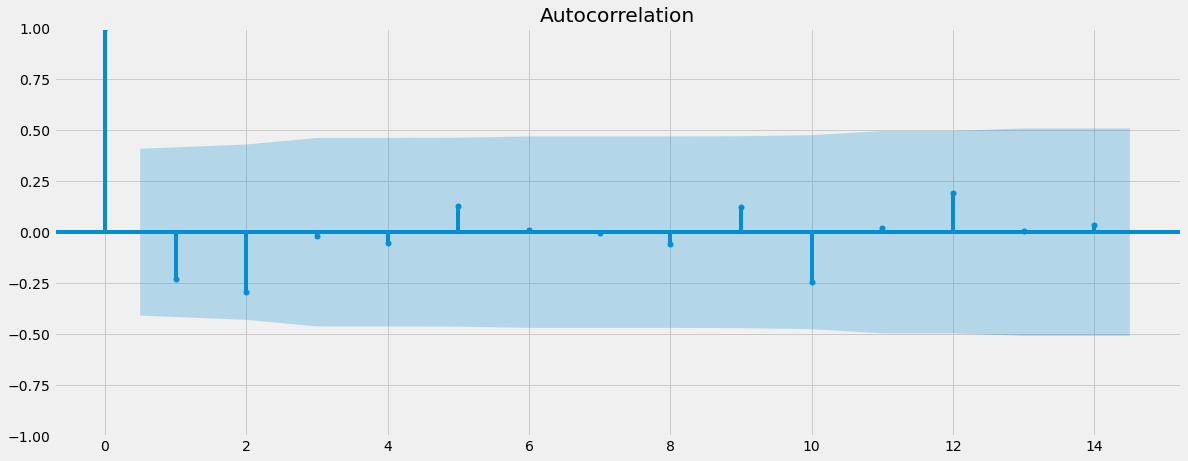

In [37]:
# Check the data_diff_2's autocorrelations

plot_acf(data_diff_2)
plt.show()